## Questions

1.	What factors play into police stops.
    a.	Given pieces of data about a particular stop, to what extent can we predict the race of the subject. 
    i.	AM vs PM 
2.	Can we predict what precincts that are more likely to pull over a particular gender/race. 
    a.	AM vs PM
3.	What is the correlation of prerace actually being accurate to actual race. 
4.	Are there times of higher citations. Morning, Afternoon, Evening, Night. 
5. Does the type of traffic stop impact whether a person is searched? H1 If suspicious vehicle stops are related to a person being searched, then the percentage of searches will be higher than the regular traffic stops for the year; H0 If suspicious vehicle stops are not related to a person being serarched, then the percentage of searches will be approximately equal for the year.



In [1]:
# importing dependencies
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import requests
import time
import json
import datetime
from pprint import pprint

# Google developer API key
#from config import google_key

# Census developer API key
#from config import census_key

## Data Load, Prep and Review

In [2]:
# reading csv file
StopOriginal = pd.read_csv('MplsStops_base.csv', parse_dates=['date'], infer_datetime_format=True)

StopOriginal['Time'] = StopOriginal.date.dt.time

# def get_sec(time_str):
#     h, m, s = time_str.split(':')
#     return int(h) * 3600 + int(m) * 60 + int(s)

# for time in StopOriginal:
#     convertedTime = get_sec(time['Time'])
#     StopOriginal.append({'convertedTime': convertedTime})

# displaying file header and five rows
StopOriginal.head()


,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
0,6823,17-000003,2017-01-01 00:00:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside,00:00:00
1,6824,17-000007,2017-01-01 00:03:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West,00:03:00
2,6825,17-000073,2017-01-01 00:23:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier,00:23:00
3,6826,17-000092,2017-01-01 00:33:00,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier,00:33:00
4,6827,17-000098,2017-01-01 00:37:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West,00:37:00


In [3]:
StopOriginal.dtypes

Unnamed: 0                 int64
idNum                     object
date              datetime64[ns]
problem                   object
MDC                       object
citationIssued            object
personSearch              object
vehicleSearch             object
preRace                   object
race                      object
gender                    object
lat                      float64
long                     float64
policePrecinct             int64
neighborhood              object
Time                      object
dtype: object

### Total Stops per Precinct

In [4]:
#stops per precinct 
StopOriginal['policePrecinct'].value_counts()

5    12825
4    12273
3     9792
2     9478
1     7552
Name: policePrecinct, dtype: int64

In [5]:
# storing csv into a pandas dataframe
initDF = pd.DataFrame(StopOriginal)
initDF.head()

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
0,6823,17-000003,2017-01-01 00:00:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside,00:00:00
1,6824,17-000007,2017-01-01 00:03:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West,00:03:00
2,6825,17-000073,2017-01-01 00:23:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier,00:23:00
3,6826,17-000092,2017-01-01 00:33:00,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier,00:33:00
4,6827,17-000098,2017-01-01 00:37:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West,00:37:00


### Count of Stops (Removed 'other' values from MCD column)

In [6]:
#stops per police precinct after removing 'other' values from MDC column
cleanDF = initDF.drop(initDF[initDF.MDC == 'other'].index)
cleanDF['policePrecinct'].value_counts()

5    11435
4    10726
3     8345
2     7944
1     5249
Name: policePrecinct, dtype: int64

In [7]:
#data just for precinct 1 
precinct_one = cleanDF.loc[cleanDF['policePrecinct'] == 1 ]
precinct_two = cleanDF.loc[cleanDF['policePrecinct'] == 2 ]
precinct_three = cleanDF.loc[cleanDF['policePrecinct'] == 3 ]
precinct_four = cleanDF.loc[cleanDF['policePrecinct'] == 4 ]
precinct_five = cleanDF.loc[cleanDF['policePrecinct'] == 5 ]

In [8]:
one = precinct_one['problem'].value_counts()
one

suspicious    3326
traffic       1923
Name: problem, dtype: int64

### Total Stops

In [9]:
# calculating total stops 
precinct_df = pd.DataFrame(cleanDF['policePrecinct'].value_counts())
stops = precinct_df['policePrecinct'].sum()
stops

43699

### Count/Percent of Stops by Race

,race,%
Black,15220,34.83%
White,11703,26.78%
Unknown,9219,21.10%
East African,2188,5.01%
Latino,1858,4.25%
Native American,1516,3.47%
Other,1348,3.08%
Asian,647,1.48%


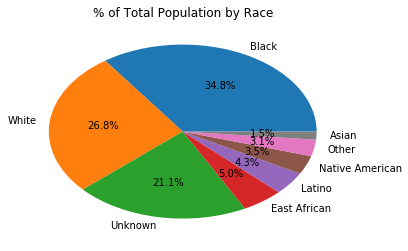

In [10]:
# Count of Stops by Race
race_count = pd.DataFrame(cleanDF['race'].value_counts())
race_count['%'] = race_count['race'] / stops * 100
race_count['%'] = race_count['%'].map("{:.2f}%".format)
display(race_count)
labels = ['Black','White', 'Unknown', 'East African', 'Latino', 'Native American', 'Other', 'Asian']
plt.pie(race_count['race'], labels=labels, autopct="%1.1f%%")
# adding title
plt.title("% of Total Population by Race")
# save the figure
plt.savefig("percent_pop_race.png")
# show the figure
plt.show()

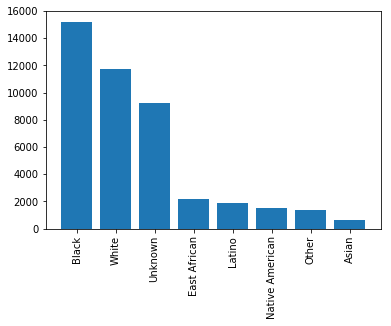

In [398]:
# the labels need to be fixed and despite about 5 attempts, I cannot find the magical code to do that
race_type = ['Black','White', 'Unknown', 'East African', 'Latino', 'Native American', 'Other', 'Asian']
race_cnts = race_count['race'].values.tolist()
plt.bar(race_type, race_cnts,  align='center')
plt.xticks(rotation='vertical')
plt.show()

## Q4: Are there instances of higher stops by morning, afternoon, evening, night?

In [12]:
# grouping by time of day
cleanDF['id_date'] = pd.to_datetime(cleanDF['date'], errors='coerce')
cleanDF.set_index('id_date', inplace=True)
# timeDF = cleanDF.groupby(['policePrecinct', pd.Grouper(key='date',freq='6h')]) ['problem'].value_counts()
# timeDF

grouper = pd.Grouper(freq='6h')
cleanDF.index = cleanDF.reset_index()['id_date'].apply(lambda x: x - pd.Timestamp(x.date()))
time_of_day = cleanDF.groupby(grouper).count()
time_of_day



,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
id_date,,,,,,,,,,,,,,,,
00:00:00,8813,8813,8813,8813,8813,3531,8813,8813,8813,8813,8799,8813,8813,8813,8813,8813
06:00:00,6681,6681,6681,6681,6681,3103,6681,6681,6681,6681,6673,6681,6681,6681,6681,6681
12:00:00,11809,11809,11809,11809,11809,5466,11809,11809,11809,11809,11793,11809,11809,11809,11809,11809
18:00:00,16396,16396,16396,16396,16396,7010,16396,16396,16396,16396,16373,16396,16396,16396,16396,16396


In [13]:
timeDF = cleanDF.groupby(grouper) ['policePrecinct'].value_counts()
timeDF = pd.DataFrame(timeDF)
timeDF

policePrecinct
id_date  policePrecinct                
00:00:00 2                         2049
         5                         1951
         3                         1790
         1                         1512
         4                         1511
06:00:00 5                         2362
         2                         1343
         3                         1249
         4                         1137
         1                          590
12:00:00 4                         4000
         5                         3084
         3                         2020
         2                         1718
         1                          987
18:00:00 4                         4078
         5                         4038
         3                         3286
         2                         2834
         1                         2160

In [14]:
timeDF4 = cleanDF.groupby([grouper, 'problem']) ['race'].value_counts()
timeDF4 = pd.DataFrame(timeDF4)
timeDF4

race
id_date  problem    race                 
00:00:00 suspicious Unknown          1623
                    Black            1348
                    White             851
                    Native American   189
                    Latino            139
                    East African      111
                    Other             100
                    Asian              29
         traffic    Black            2091
                    White            1236
                    East African      327
                    Latino            303
                    Other             168
                    Unknown           146
                    Asian              86
                    Native American    66
06:00:00 suspicious Unknown          1405
                    Black             667
                    White             601
                    Native American   304
                    Other             105
                    Latino             72
                    East African       49
                    Asian              22
         traffic    White            1838
                    Black             979
                    Latino            195
                    East African      143
                    Other             107
                    Asian              83
...                                   ...
12:00:00 suspicious White             976
                    Native American   370
                    East African      173
                    Other             141
                    Latino            118
                    Asian              38
         traffic    Black            2814
                    White            2041
                    Latino            303
                    East African      299
                    Unknown           290
                    Other             171
                    Asian             129
                    Native American    89
18:00:00 suspicious Unknown          3057
                    Black            1964
                    White            1108
                    Native American   314
                    East African      310
                    Latino            202
                    Other             191
                    Asian              51
         traffic    Black            3878
                    White            3052
                    East African      776
                    Latino            526
                    Other             365
                    Unknown           261
                    Asian             209
                    Native American   132

[64 rows x 1 columns]

In [451]:
timeDF2 = cleanDF.groupby(grouper) ['problem'].value_counts()
timeDF2 = pd.DataFrame(timeDF2)
timeDF2 = timeDF2.rename(columns={'problem':'count'})




In [452]:
timeDF3 = cleanDF.groupby(grouper)['race'].value_counts()
timeDF3 = pd.DataFrame(timeDF3)
timeDF3




race
id_date  race                 
00:00:00 Black            3439
         White            2087
         Unknown          1769
         Latino            442
         East African      438
         Other             268
         Native American   255
         Asian             115
06:00:00 White            2439
         Black            1646
         Unknown          1464
         Native American   356
         Latino            267
         Other             212
         East African      192
         Asian             105
12:00:00 Black            4293
         White            3017
         Unknown          2668
         East African      472
         Native American   459
         Latino            421
         Other             312
         Asian             167
18:00:00 Black            5842
         White            4160
         Unknown          3318
         East African     1086
         Latino            728
         Other             556
         Native American   446
         Asian             260

### Stops by Race per Precinct

In [131]:
# stops per precinct by race
# count of stops per race per precinct
one_race_count = pd.DataFrame(precinct_one['race'].value_counts())
one_race_count = one_race_count.rename(columns={'race':'one'})

two_race_count = pd.DataFrame(precinct_two['race'].value_counts())
two_race_count = two_race_count.rename(columns={'race':'two'})

three_race_count = pd.DataFrame(precinct_three['race'].value_counts())
three_race_count = three_race_count.rename(columns={'race':'three'})

four_race_count = pd.DataFrame(precinct_four['race'].value_counts())
four_race_count = four_race_count.rename(columns={'race':'four'})

five_race_count = pd.DataFrame(precinct_five['race'].value_counts())
five_race_count = five_race_count.rename(columns={'race':'five'})

#stops per precinct by race
stops_per_precinct_by_race = pd.concat([one_race_count,two_race_count,three_race_count,four_race_count,five_race_count], axis=1, sort=True)
stops_per_precinct_by_race = stops_per_precinct_by_race.reset_index()
stops_per_precinct_by_race = stops_per_precinct_by_race.rename(columns={'index':'race'})
stops_per_precinct_by_race = stops_per_precinct_by_race[['race','one','two','three','four','five']]
stops_per_precinct_by_race['Total'] = stops_per_precinct_by_race.sum(axis=1)

stops_per_precinct_by_race




,race,one,two,three,four,five,Total
0,Asian,65,165,53,177,187,647
1,Black,2176,2226,2059,6183,2576,15220
2,East African,286,364,463,127,948,2188
3,Latino,100,429,543,216,570,1858
4,Native American,192,119,750,108,347,1516
5,Other,165,304,273,228,378,1348
6,Unknown,897,1033,2893,2494,1902,9219
7,White,1368,3304,1311,1193,4527,11703


### Stops By Precinct Per Race Scatter Plots

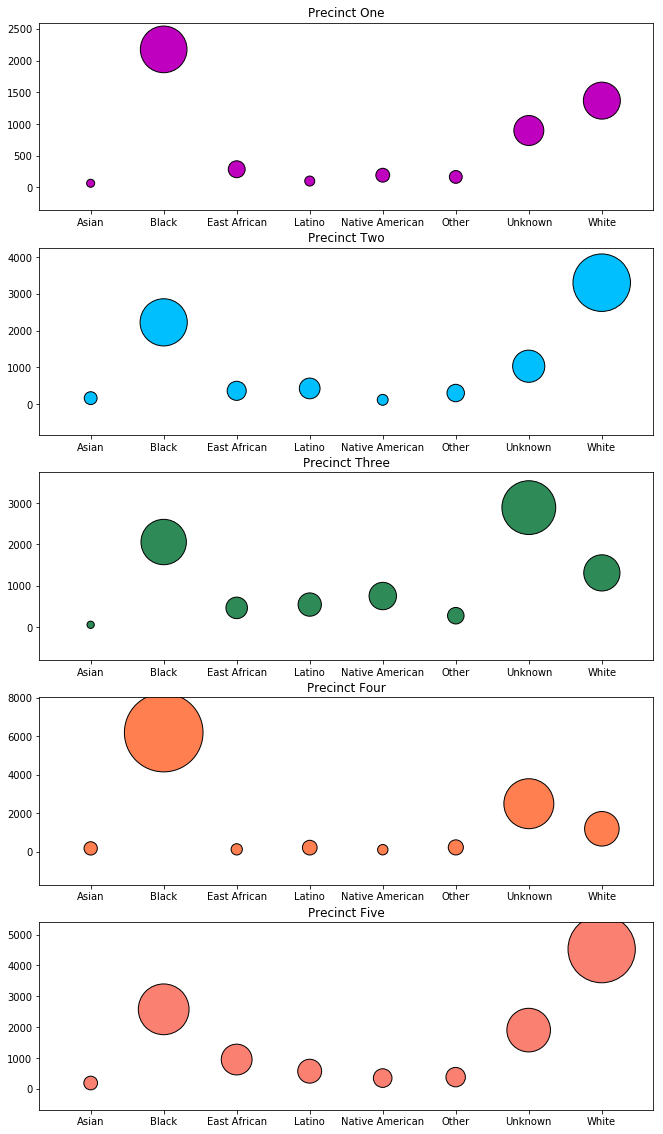

In [431]:
#splitting up df to segment by precicnt
stppbr = stops_per_precinct_by_race
stppbr

one = pd.DataFrame(stppbr.iloc[:, [0,1]])  
two = pd.DataFrame(stppbr.iloc[:, [0,2]]) #data.iloc[[0,3,6,24], [0,5,6]]
three = pd.DataFrame(stppbr.iloc[:, [0,3]])
four = pd.DataFrame(stppbr.iloc[:, [0,4]])
five = pd.DataFrame(stppbr.iloc[:, [0,5]])
six = pd.DataFrame(stppbr.iloc[:, [0,6]])

#plotting
fig1,ax = plt.subplots(5,1 , figsize=(11,20))

ax[0].scatter(one.race,one.one, s=one.one, color='m', label='One',linewidths=1 ,edgecolor='black')
ax[1].scatter(two.race,two.two, s=two.two, color='deepskyblue', label='Two',linewidths=1 ,edgecolor='black')
ax[2].scatter(three.race,three.three, s=three.three, color='seagreen', label='Three',linewidths=1 ,edgecolor='black')
ax[3].scatter(four.race,four.four, s=four.four, color='coral', label='Four',linewidths=1 ,edgecolor='black')
ax[4].scatter(five.race,five.five, s=five.five, color='salmon', label='Five',linewidths=1 ,edgecolor='black')

ax[0].margins(x=0.1,y=0.2) 
ax[1].margins(x=0.1,y=0.3) 
ax[2].margins(x=0.1,y=0.3) 
ax[3].margins(x=0.1,y=0.3) 
ax[4].margins(x=0.1,y=0.2) 

ax[0].set_title('Precinct One')
ax[1].set_title('Precinct Two')
ax[2].set_title('Precinct Three')
ax[3].set_title('Precinct Four')
ax[4].set_title('Precinct Five')

fig1.savefig('Stops_per_precinct_by_race.png')

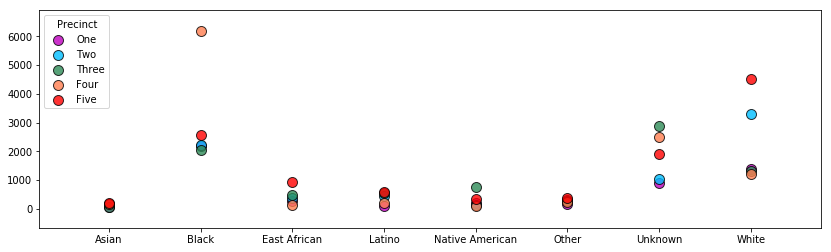

In [559]:
stppbr = stops_per_precinct_by_race
stppbr

one = pd.DataFrame(stppbr.iloc[:, [0,1]])  
two = pd.DataFrame(stppbr.iloc[:, [0,2]]) #data.iloc[[0,3,6,24], [0,5,6]]
three = pd.DataFrame(stppbr.iloc[:, [0,3]])
four = pd.DataFrame(stppbr.iloc[:, [0,4]])
five = pd.DataFrame(stppbr.iloc[:, [0,5]])
six = pd.DataFrame(stppbr.iloc[:, [0,6]])

#plotting
fig8,ax8 = plt.subplots( figsize=(14,4))

ax8.scatter(one.race,one.one, s=100, color='m', label='One',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(two.race,two.two, s=100, color='deepskyblue', label='Two',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(three.race,three.three, s=100, color='seagreen', label='Three',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(four.race,four.four, s=100, color='coral', label='Four',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(five.race,five.five, s=100, color='r', label='Five',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.margins(x=0.1,y=0.2) 
ax8.legend(loc='upper left',title='Precinct')
ax8.margins(x=0.1,y=0.1) 

fig8.savefig('Stops_per_precinct_by_race2.png')

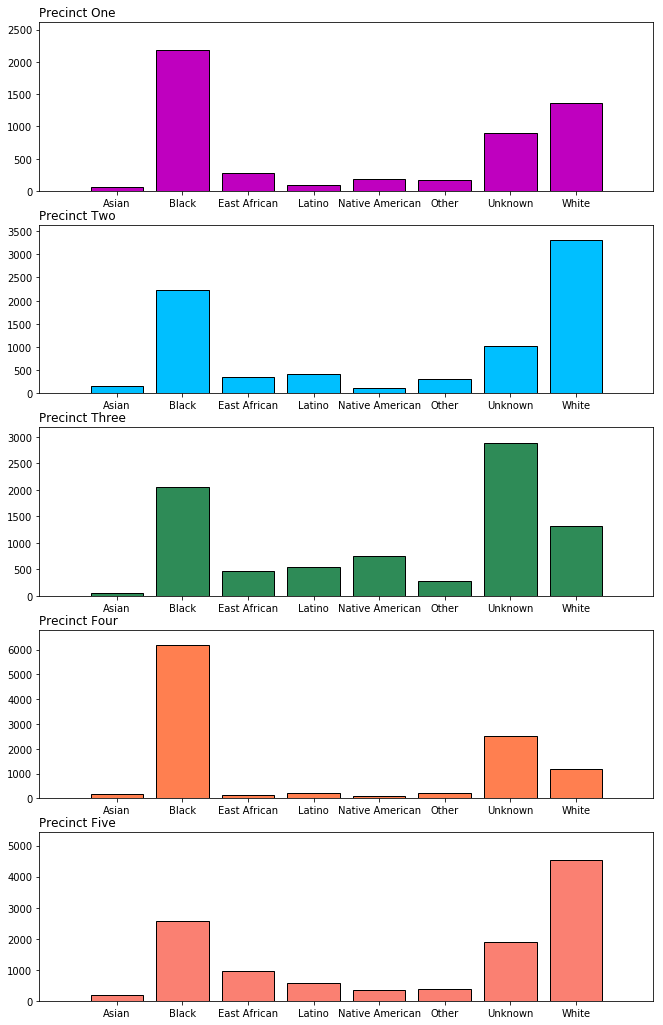

In [345]:
##splitting up df to segment by precicnt
fig2,ax = plt.subplots(5,1 , figsize=(11,18))

ax[0].bar(one.race,one.one,  color='m', label='One' ,edgecolor='black')
ax[1].bar(two.race,two.two,  color='deepskyblue', label='Two' ,edgecolor='black')
ax[2].bar(three.race,three.three,  color='seagreen', label='Three' ,edgecolor='black')
ax[3].bar(four.race,four.four,  color='coral', label='Four' ,edgecolor='black')
ax[4].bar(five.race,five.five,  color='salmon', label='Five' ,edgecolor='black')

ax[0].margins(x=0.1,y=0.2) 
ax[1].margins(x=0.1,y=0.1) 
ax[2].margins(x=0.1,y=0.1) 
ax[3].margins(x=0.1,y=0.1) 
ax[4].margins(x=0.1,y=0.2) 

ax[0].set_title('Precinct One',loc='left')
ax[1].set_title('Precinct Two',loc='left')
ax[2].set_title('Precinct Three',loc='left')
ax[3].set_title('Precinct Four',loc='left')
ax[4].set_title('Precinct Five',loc='left')

fig2.savefig('Stops_per_precinct_by_race_bar.png')

### Total Stops Per Race

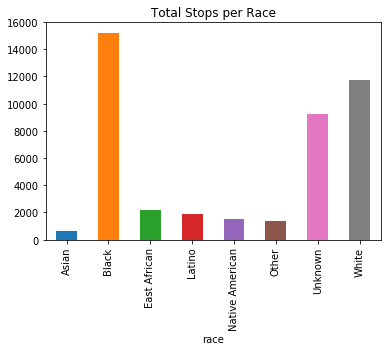

In [184]:
Total_Stops_Per_Race = stppbr.plot(kind='bar',x='race',y='Total',legend=None, title='Total Stops per Race')


### Stops by Gender per Precinct

In [140]:
# precinct stops by gender
one_sex = pd.DataFrame(precinct_one['gender'].value_counts())
two_sex = pd.DataFrame(precinct_two['gender'].value_counts())
three_sex = pd.DataFrame(precinct_three['gender'].value_counts())
four_sex = pd.DataFrame(precinct_four['gender'].value_counts())
five_sex = pd.DataFrame(precinct_five['gender'].value_counts())

precincts_sex = pd.concat([one_sex,two_sex,three_sex,four_sex,five_sex] , axis=1, sort=False)
precincts_sex.columns = ['One','Two','Three','Four','Five']
precincts_sex['Total'] = precincts_sex.sum(axis=1)
precincts_sex['%'] = precincts_sex['Total'] / precincts_sex['Total'].sum() * 100 
precincts_sex['%'] = precincts_sex['%'].map("{:.2f}%".format)
precincts_sex



,Gender,One,Two,Three,Four,Five,Total,%
0,Male,3664,5181,4816,6468,7002,27131,62.17%
1,Female,985,2109,1598,2297,3026,10015,22.95%
2,Unknown,593,645,1922,1943,1389,6492,14.88%


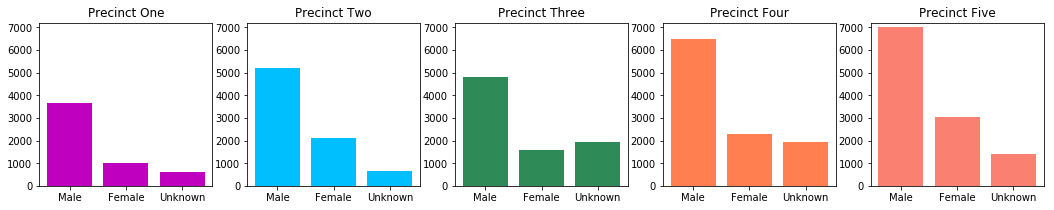

In [487]:
#chart to show num of stops per gender for each precinct

x = ('Male','Female','Unknown')
y1 = precincts_sex['One']
y2 = precincts_sex['Two']
y3 = precincts_sex['Three']
y4 = precincts_sex['Four']
y5 = precincts_sex['Five']

fig6, ax6 = subplots(1,5 , figsize=(18,3))
ax6[0].bar(x,y1,  color='m')
ax6[0].set_ylim(0,7200)
ax6[0].set_title('Precinct One')

ax6[1].bar(x,y2,  color='deepskyblue')
ax6[1].set_ylim(0,7200)
ax6[1].set_title('Precinct Two')

ax6[2].bar(x,y3,  color='seagreen')
ax6[2].set_ylim(0,7200)
ax6[2].set_title('Precinct Three')

ax6[3].bar(x,y4,  color='coral')
ax6[3].set_ylim(0,7200)
ax6[3].set_title('Precinct Four')

ax6[4].bar(x,y5,  color='salmon')
ax6[4].set_ylim(0,7200)
ax6[4].set_title('Precinct Five')

fig6.savefig('Stops_per_precinct_by_gender_bar.png')

### Total Stops by Gender

In [218]:
# total stops by gender
stop_by_gender = precincts_sex[['Total','%']]
stop_by_gender

sbg = pd.DataFrame(stop_by_gender)
sbg = sbg.reset_index()
sbg = sbg.rename(columns={'index':'Gender'})
sbg

,Gender,Total,%
0,Male,27131,62.17%
1,Female,10015,22.95%
2,Unknown,6492,14.88%


### Accuracy of Pre-determined Race vs. Actual Race

In [22]:
#reading the csv
#pre_race_count = pd.DataFrame(cleanDF['preRace'].value_counts())

#summarizing data for preRace vs Race 
#e_test = e_test.loc[e_test['MDC'] == 'MDC']

#data table with only preRace classfication
pre_race = cleanDF.loc[cleanDF['preRace'] != 'Unknown'] #should we filter out other?

#see how many times preRace matched race
race_match = pre_race.loc[pre_race['preRace'] == pre_race['race']]
race_match_count = len(race_match)
print(f'{race_match_count} times preRace matched actual Race')

#see how many times preRace DID NOT match actual race
race_NA_match = pre_race.loc[pre_race['preRace'] != pre_race['race']]
race_NA_match_count = len(race_NA_match)
print(f'{race_NA_match_count} times preRace did not match Race')

race_predictions = pd.DataFrame(
                                {"Pre_Race matched Actuall Race" : [race_match_count],
                                "Pre_Race did not match Actuall Race" : [race_NA_match_count]
                                 })
race_predictions

12573 times preRace matched actual Race
2789 times preRace did not match Race


,Pre_Race matched Actuall Race,Pre_Race did not match Actuall Race
0,12573,2789


In [ ]:
pre_race_count = pd.DataFrame(pre_race['preRace'].value_counts())
pre_race_count

In [45]:
#count of stops per precinct where preRace was determined 
one_count = len(pre_race.loc[pre_race['policePrecinct'] == 1])
two_count = len(pre_race.loc[pre_race['policePrecinct'] == 2])
three_count = len(pre_race.loc[pre_race['policePrecinct'] == 3])
four_count = len(pre_race.loc[pre_race['policePrecinct'] == 4])
five_count = len(pre_race.loc[pre_race['policePrecinct'] == 5])

#Breaking out by precinct whre pre race macthed actual race
race_match_one = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 1) ]
race_match_two = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 2) ]
race_match_three = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 3) ]
race_match_four = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 4) ]
race_match_five= pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 5) ]

#count of how many times each precinct matched the race correctly 
precinct_one_count = len(race_match_one)
precinct_two_count = len(race_match_two)
precinct_three_count = len(race_match_three)
precinct_four_count = len(race_match_four)
precinct_five_count = len(race_match_five)

#percent of each precinct match rate
preccint_one_percent = round(precinct_one_count / one_count * 100,2)
preccint_two_percent = round(precinct_two_count / two_count * 100,2)
preccint_three_percent = round(precinct_three_count / three_count * 100,2)
preccint_four_percent = round(precinct_four_count / four_count * 100,2)
preccint_five_percent = round(precinct_five_count / five_count * 100,2)


#print findings
print(f'Match count for precinct One {precinct_one_count}')
print(f'Precinct One was correct {preccint_one_percent}% of the time')
print("")
print(f'Match count for precinct Two {precinct_two_count}')
print(f'Precinct Two was correct {preccint_two_percent}% of the time')
print("")
print(f'Match count for precinct Three {precinct_three_count}')
print(f'Precinct Three was correct {preccint_three_percent}% of the time')
print("")
print(f'Match count for precinct Four {precinct_four_count}')
print(f'Precinct Four was correct {preccint_four_percent}% of the time')
print("")
print(f'Match count for precinct Five {precinct_five_count}')
print(f'Precinct Five was correct {preccint_five_percent}% of the time')
print("")

Match count for precinct One 2059
Precinct One was correct 87.92% of the time

Match count for precinct Two 2083
Precinct Two was correct 86.65% of the time

Match count for precinct Three 2097
Precinct Three was correct 69.41% of the time

Match count for precinct Four 2452
Precinct Four was correct 83.12% of the time

Match count for precinct Five 3882
Precinct Five was correct 83.57% of the time



In [121]:
#creating df
precint_match_df = pd.DataFrame({ 'Matches':[precinct_one_count,precinct_two_count,precinct_three_count,precinct_four_count,precinct_five_count],
                                  'Match_Rate' :[preccint_one_percent,preccint_two_percent,preccint_three_percent,preccint_four_percent,preccint_five_percent]},
                                     index=[1,2,3,4,5])
precint_match_df['Match_Rate'] = precint_match_df['Match_Rate'].map("{:.2f}%".format)

precint_match_df.index.name = 'Precinct'
precint_match_df






,Matches,Match_Rate
Precinct,,
1,2059,87.92%
2,2083,86.65%
3,2097,69.41%
4,2452,83.12%
5,3882,83.57%


## Initial Plots / Testing

### Testing

In [50]:
citation_search

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
id_date,,,,,,,,,,,,,,,,
19:47:00,36665,17-252348,2017-07-06 19:47:00,traffic,MDC,YES,YES,YES,Black,Black,Male,44.999520,-93.300660,4,Willard - Hay,19:47:00
13:17:00,36785,17-253340,2017-07-07 13:17:00,traffic,MDC,YES,NO,YES,Unknown,Latino,Male,45.000860,-93.286473,4,Hawthorne,13:17:00
02:49:00,36927,17-254531,2017-07-08 02:49:00,traffic,MDC,YES,YES,YES,Black,Black,Male,44.948370,-93.252500,3,East Phillips,02:49:00
01:06:00,37019,17-255723,2017-07-09 01:06:00,traffic,MDC,YES,YES,YES,Unknown,White,Male,45.017625,-93.291811,4,McKinley,01:06:00
12:45:00,37168,17-257363,2017-07-10 12:45:00,traffic,MDC,YES,YES,YES,Unknown,Black,Female,44.995230,-93.292580,4,Near - North,12:45:00
13:42:00,37177,17-257438,2017-07-10 13:42:00,suspicious,MDC,YES,YES,YES,Unknown,Black,Male,45.023990,-93.295640,4,Webber - Camden,13:42:00
02:04:00,37284,17-258374,2017-07-11 02:04:00,traffic,MDC,YES,NO,YES,Unknown,Black,Male,44.998704,-93.262406,2,St. Anthony West,02:04:00
02:46:00,37289,17-258406,2017-07-11 02:46:00,traffic,MDC,YES,YES,YES,Unknown,Black,Male,45.019504,-93.300641,4,Folwell,02:46:00
13:01:00,37357,17-258863,2017-07-11 13:01:00,traffic,MDC,YES,YES,YES,Black,Black,Male,45.007820,-93.306950,4,Jordan,13:01:00


In [56]:
#table where vechile was searched and citation was issued. 

citation_search = cleanDF.loc[(cleanDF['citationIssued'] == 'YES') & (cleanDF['vehicleSearch'] == 'YES')]
vech_search_cit = pd.DataFrame(citation_search.groupby(['race'])['race'].count())
vech_search_cit = vech_search_cit.rename(columns={'race':'Count'})


,Count
race,
Asian,3
Black,223
East African,14
Latino,25
Native American,4
Other,8
Unknown,11
White,53


In [ ]:
>>> data.groupby(['col1', 'col2'])['col3'].mean()
